In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from itertools import permutations
from sklearn.decomposition import PCA

np.random.seed(42)

%matplotlib inline

In [3]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [4]:
# load gene level profiles 
df_gene = pd.read_csv(os.path.join(output_folder,'20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_guide_normalized_merged_feature_select_median_ALLWELLS_gene_aggregated.csv.gz')).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
# load hit lists 
whole_cell_hits = pd.read_csv(os.path.join(output_folder,'HeLa_SABER_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
comp_spec_hits = pd.read_csv(os.path.join(output_folder,'HeLa_SABER_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')
hit_list = list(comp_spec_hits.index) + list(whole_cell_hits.index)
df_hits = df_gene.loc[df_gene.index.isin(hit_list)]
df_hits

,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,Cells_AreaShape_CentralMoment_2_3,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,...,Nuclei_Texture_SumEntropy_PRSP6_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_Syto9_10_03_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
ABCF1,-0.060312,0.147953,-0.499430,-0.480239,0.015687,0.076740,-0.687840,-0.130226,0.293780,-0.189723,...,1.211825,-0.960585,0.192730,-0.032408,-0.107133,-0.381875,0.785110,1.032315,1.076095,0.045420
ACTR2,0.010109,-0.033853,0.150085,0.098019,-0.049430,-0.000416,0.047961,0.080113,-2.250000,0.824810,...,1.502300,3.948900,1.080285,0.507495,1.133240,0.378950,-0.444100,1.053490,-0.458410,1.284000
ACTR3,0.018373,-0.009114,0.023851,0.046670,0.116575,0.020802,0.009752,-0.004125,-1.898300,1.832850,...,0.510010,2.870150,1.265700,0.085870,1.035450,0.615430,-0.161935,0.792815,-0.475570,0.758960
ADAR,-0.056948,0.193425,0.040800,-0.016710,-0.115169,0.014768,-0.002475,-0.040692,-0.240685,0.396830,...,-0.320125,-0.508175,-0.240020,-0.215960,-0.209105,-0.362375,0.661090,0.554710,0.774045,-0.090365
ALG13,-0.266518,-0.455645,-0.098725,0.299485,0.147973,0.168990,0.182441,0.015312,-0.446610,0.037736,...,-0.109979,1.420500,0.487229,-0.161705,0.435615,-0.228930,-1.943100,-0.650295,-2.097700,0.540010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YWHAH,-0.022833,-0.071204,0.073385,-0.221390,-0.069182,-0.122725,-0.038804,-0.191150,-0.094486,0.034100,...,0.068070,-0.138480,-0.119555,-0.159382,-0.262465,-0.417240,-0.153436,-0.327115,-0.222010,-0.177340
ZC3H8,0.001845,-0.423155,0.490555,0.052490,0.049880,0.138930,-0.180165,-0.146645,-0.493300,0.537175,...,-0.125215,-0.912500,0.199214,0.765830,0.017160,0.398660,0.531960,0.321213,0.604615,0.453625
ZC3HC1,0.340573,-0.089564,0.282530,-0.401705,0.165095,-0.124319,0.176982,-0.058771,-0.153682,0.287885,...,-0.206965,0.616870,-0.430110,0.061355,-0.302654,-0.038280,0.324660,0.301820,0.579965,-0.401915


In [8]:
# Perform principal component analysis on gene level profiles
pca = PCA()
pca.fit(df_gene)
x = list(pca.explained_variance_ratio_)
# Find principal component that represents 90% variation
PCA_lookup = {}
for i in range(len(x)):
    distance = abs(.7-sum(x[:i+1]))
    PCA_lookup[distance] = i 
component = PCA_lookup[min(PCA_lookup.keys())]+1
print (f'Principal component representing closest to 90% variation is {component}')

# Perform principal component analysis and select components representing 90% of variation in data
pca = PCA(n_components=component)
df_gene_pca = pd.DataFrame(pca.fit_transform(df_gene),index=df_gene.index)
df_gene_pca.head()

Principal component representing closest to 90% variation is 8


,0,1,2,3,4,5,6,7
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,
AARS2,-3.495349,-7.161250,-4.778802,-0.422562,-3.741116,4.081941,2.786619,-3.870096
AARSD1,-3.468375,-4.409116,1.892979,-3.530091,-0.156901,1.257806,1.963546,0.125064
ABCF1,2.158045,-12.591090,21.090356,2.069308,7.857260,-1.215740,-3.503592,9.648659
ABLIM1,-1.261487,-4.807196,-9.615647,-1.046078,-1.484760,1.929912,0.008684,-2.446420
ACTR2,107.414314,39.210225,-16.081241,-15.887953,-1.148406,10.062396,-6.371134,-4.492307


In [9]:
# Calculate correlations, cluster and draw heatmap 
def clustered_heat_map(data,file_name,font_scale=0.8,linewidth=1):
        corr = data.corr()
        sns.set(font_scale=font_scale)

        g = sns.clustermap(
            corr, 
            vmin=-1, vmax=1, center=0,
            method = 'ward',
            figsize = (30 ,30),
            cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = linewidth,
            linecolor='white',
            cbar=False,
            cbar_kws={"shrink": .76},
        )
        ax = g.ax_heatmap
        ax.set_xlabel("")
        ax.set_ylabel("")
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        g.cax.set_visible(False)
        plt.tight_layout()
        output_file = os.path.join(f"{file_name}")
        #plt.savefig(output_file,dpi=300) 
        plt.show()

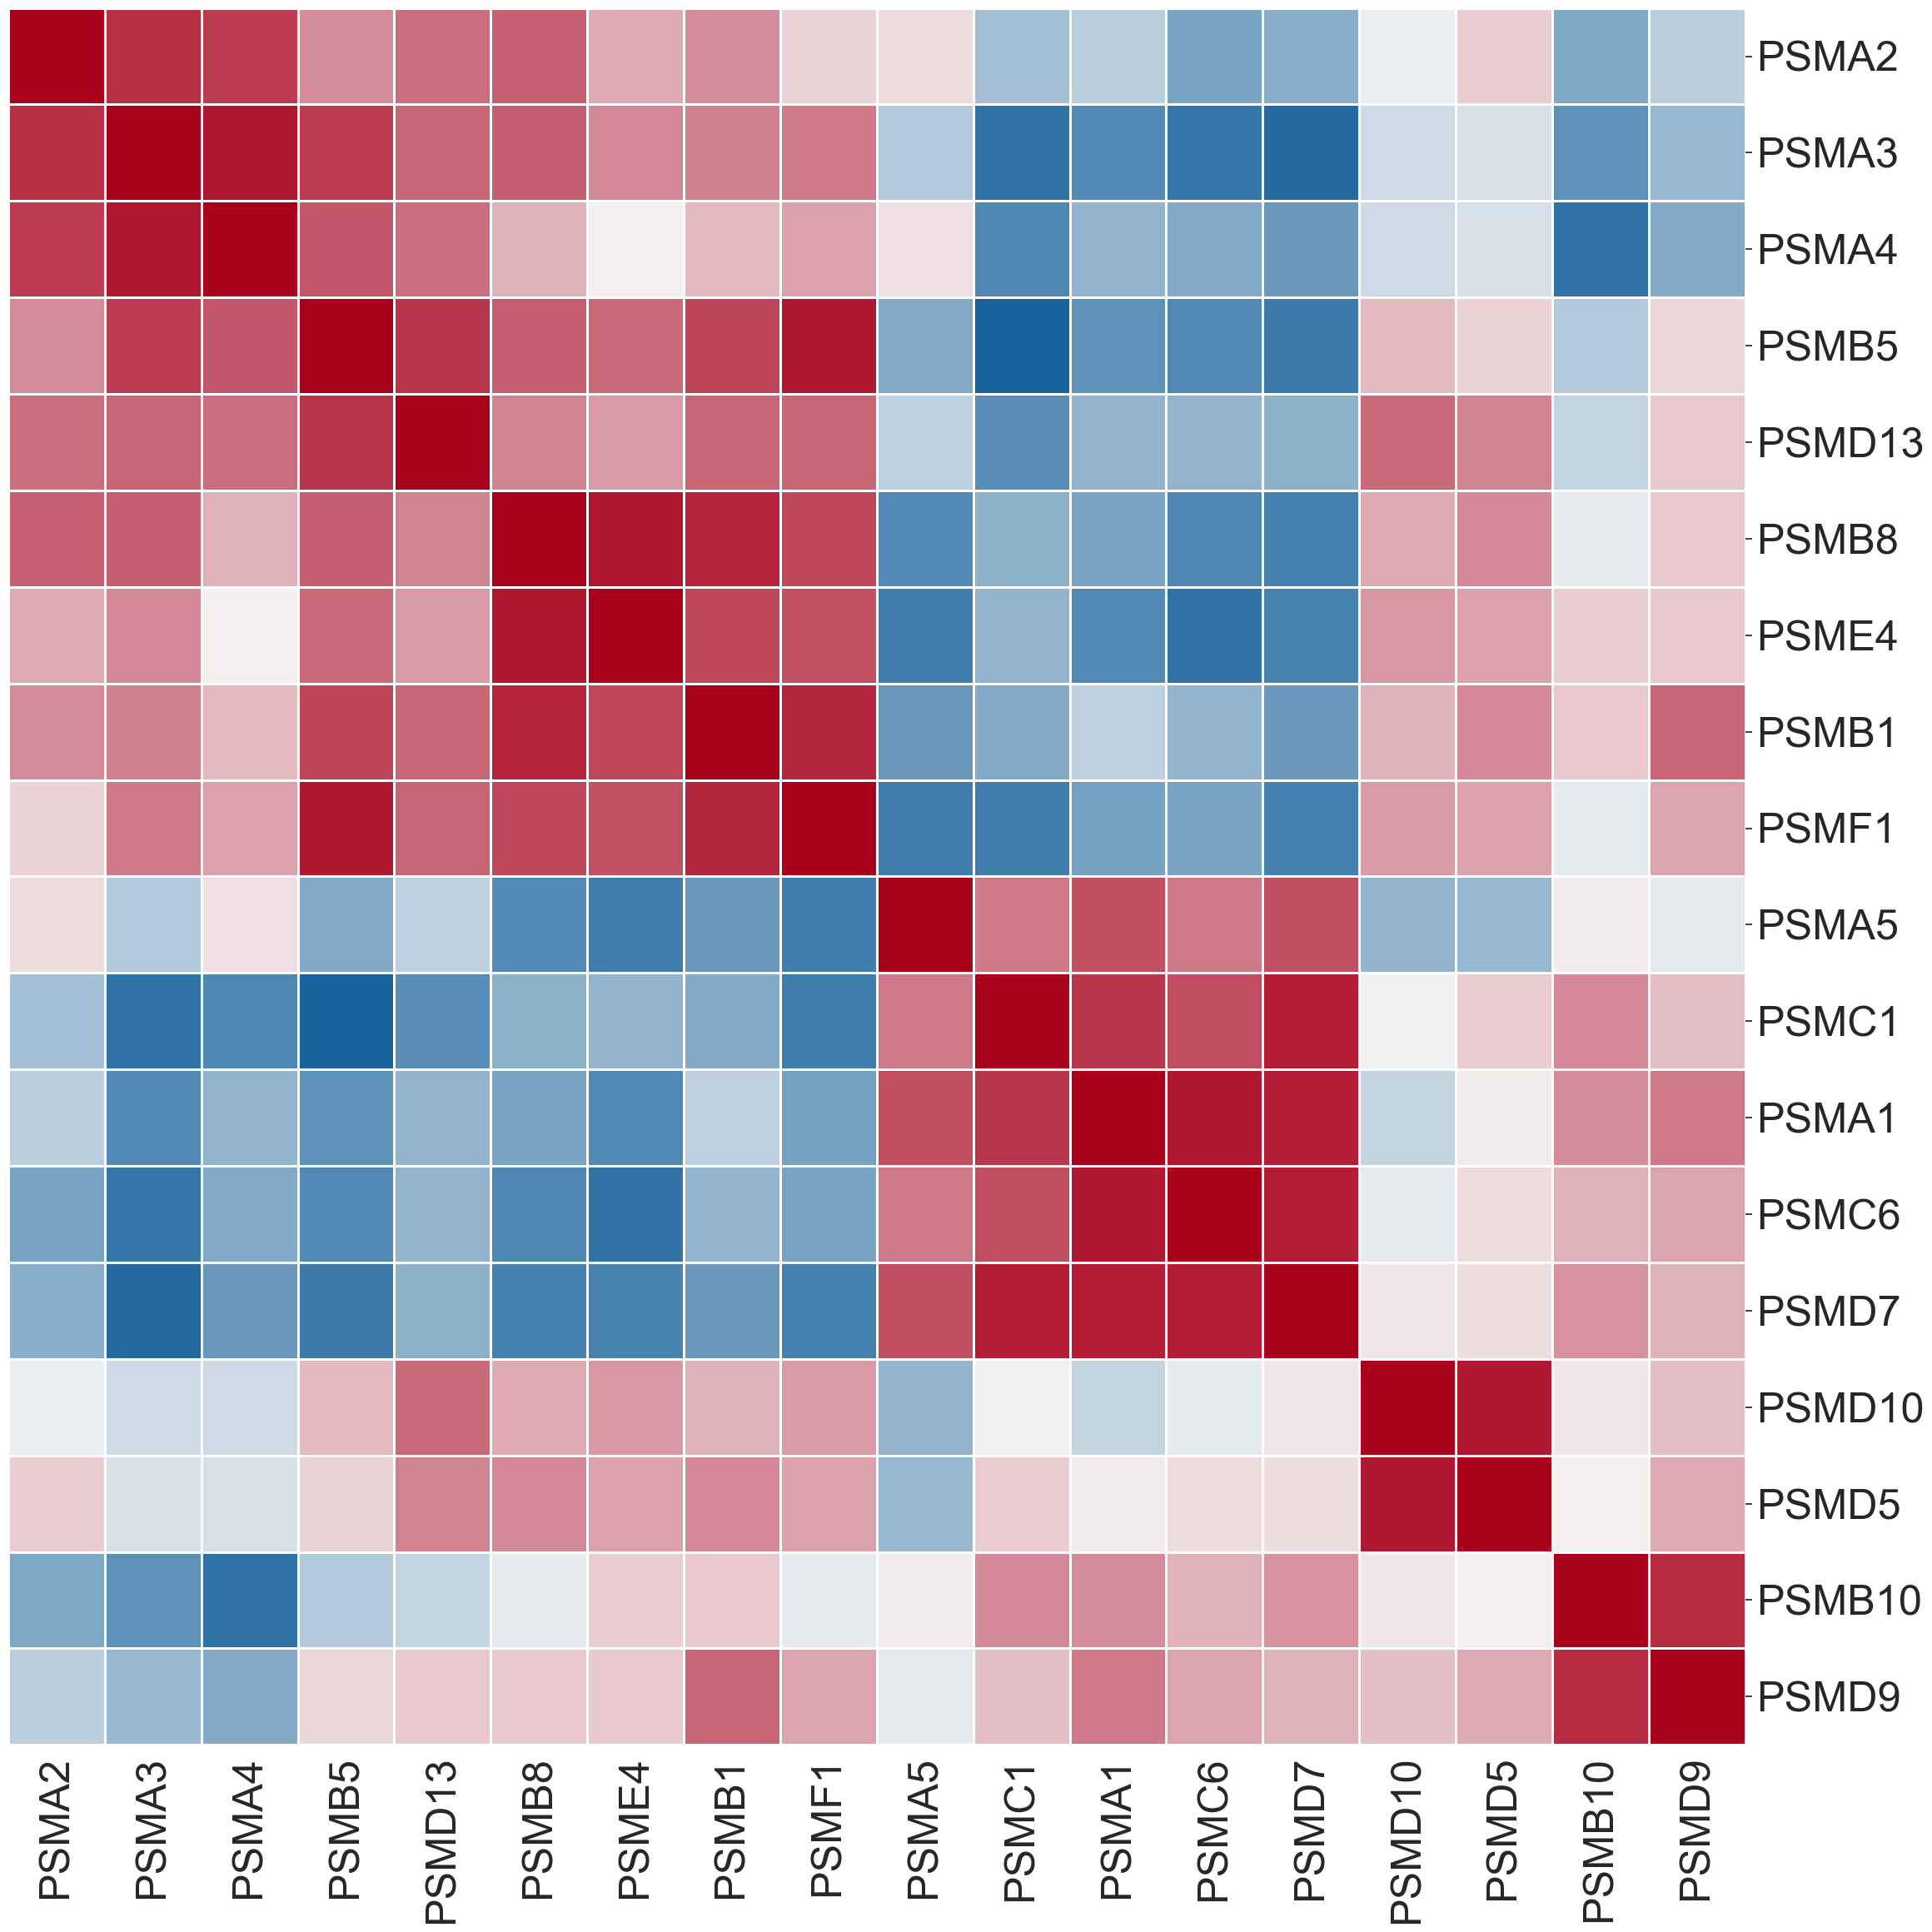

In [10]:
# Subset the gene set, calculate correlations, cluster and draw the heatmap
gene_set = 'GOCC_PROTEASOME_COMPLEX'
pre_genes_list = 'PSME3	PSMD14	ADRM1	PSMB11	PSMA8	PRICKLE1	UBR1	PSME4	ECPAS	UBQLN1	HSPB1	UCHL5	PSMA1	PSMA2	PSMA3	PSMA4	PSMA5	PSMA6	PSMA7	PSMB1	PSMB2	PSMB3	PSMB4	PSMB5	PSMB6	PSMB7	PSMB8	PSMB9	PSMB10	PSMC1	PSMC2	PSMC3	PSMC4	PSMC5	PSMC6	PSMD1	PSMD2	PSMD3	PSMD4	PSMD5	PSMD7	PSMD8	PSMD9	PSMD10	PSMD11	PSMD12	PSMD13	PSME1	PSME2	RAD23A	RAD23B	UBE3A	VCP	PAAF1	ZFAND2A	USP14	TXNL1	PSMF1	UBE3C	PSMD6'
genes_list = pre_genes_list.split('\t')
#genes_list = [i for i in genes_list if i in hit_list]
genes_df =  df_gene_pca.loc[df_gene_pca.index.isin(genes_list)]

clustered_heat_map(genes_df.T,
                   os.path.join(output_folder,'figure_panels',f'{gene_set}_heat_map.png'),
                   3.3)

In [2]:
gene_set = 'GOCC_PROTEASOME_COMPLEX'
pre_genes_list = 'PSME3	PSMD14	ADRM1	PSMB11	PSMA8	PRICKLE1	UBR1	PSME4	ECPAS	UBQLN1	HSPB1	UCHL5	PSMA1	PSMA2	PSMA3	PSMA4	PSMA5	PSMA6	PSMA7	PSMB1	PSMB2	PSMB3	PSMB4	PSMB5	PSMB6	PSMB7	PSMB8	PSMB9	PSMB10	PSMC1	PSMC2	PSMC3	PSMC4	PSMC5	PSMC6	PSMD1	PSMD2	PSMD3	PSMD4	PSMD5	PSMD7	PSMD8	PSMD9	PSMD10	PSMD11	PSMD12	PSMD13	PSME1	PSME2	RAD23A	RAD23B	UBE3A	VCP	PAAF1	ZFAND2A	USP14	TXNL1	PSMF1	UBE3C	PSMD6'
genes_list = pre_genes_list.split('\t')
genes_list

['PSME3',
 'PSMD14',
 'ADRM1',
 'PSMB11',
 'PSMA8',
 'PRICKLE1',
 'UBR1',
 'PSME4',
 'ECPAS',
 'UBQLN1',
 'HSPB1',
 'UCHL5',
 'PSMA1',
 'PSMA2',
 'PSMA3',
 'PSMA4',
 'PSMA5',
 'PSMA6',
 'PSMA7',
 'PSMB1',
 'PSMB2',
 'PSMB3',
 'PSMB4',
 'PSMB5',
 'PSMB6',
 'PSMB7',
 'PSMB8',
 'PSMB9',
 'PSMB10',
 'PSMC1',
 'PSMC2',
 'PSMC3',
 'PSMC4',
 'PSMC5',
 'PSMC6',
 'PSMD1',
 'PSMD2',
 'PSMD3',
 'PSMD4',
 'PSMD5',
 'PSMD7',
 'PSMD8',
 'PSMD9',
 'PSMD10',
 'PSMD11',
 'PSMD12',
 'PSMD13',
 'PSME1',
 'PSME2',
 'RAD23A',
 'RAD23B',
 'UBE3A',
 'VCP',
 'PAAF1',
 'ZFAND2A',
 'USP14',
 'TXNL1',
 'PSMF1',
 'UBE3C',
 'PSMD6']